In [317]:
from aind_mri_utils.file_io.neuroglancer import read_neuroglancer_annotation_layers
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import os
import shutil
import warnings


import ants
import iblatlas.atlas as atlas
import json

from aind_morphology_utils.utils import read_swc

from extract_spikes import extract_spikes
from extract_continuous import extract_continuous

import argparse

def import_swc_probe_data(filename):
    S = read_swc(filename)
    return pd.DataFrame(S.compartment_list)

def create_slicer_fcsv(filename,pts_mat,direction = 'LPS',pt_orientation = [0,0,0,1],pt_visibility = 1,pt_selected = 0, pt_locked = 1):
    """
    Save fCSV file that is slicer readable.
    """
    # Create output file
    OutObj = open(filename,"w+")
    
    header0 = '# Markups fiducial file version = 4.11\n'
    header1 = '# CoordinateSystem = '+ direction+'\n'
    header2 = '# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID\n'
    
    OutObj.writelines([header0,header1,header2])
    
    outlines = []
    for ii in range(pts_mat.shape[0]):
        outlines.append(
            str(ii+1) +','+ 
            str(pts_mat[ii,0])+','+ 
            str(pts_mat[ii,1])+','+ 
            str(pts_mat[ii,2])+
            f',{pt_orientation[0]},{pt_orientation[1]},{pt_orientation[2]},{pt_orientation[3]},'+
            f'{pt_visibility},{pt_selected},{pt_locked},'+ 
            str(ii)+',,vtkMRMLScalarVolumeNode1\n')
    
    OutObj.writelines(outlines)
    OutObj.close()
    
def probe_df_to_fcsv(probe_data,extrema,results_folder,offset=(0,0,0)):
    unq = np.unique(probe_data.tree_id)
    probes = {}
    for ii,uu in enumerate(unq):
        this_probe_data = probe_data[probe_data.tree_id==uu]
        x = extrema[0]-(this_probe_data.x/1000).values+offset[0]
        y = (this_probe_data.y/1000).values+offset[1]
        z = -(this_probe_data.z/1000).values+offset[2]    
        probes[str(uu)] = np.vstack([x,y,z]).T
        create_slicer_fcsv(os.path.join(results_folder,f'test{uu}.fcsv'),probes[str(uu)],direction = 'LPS')
        
    return probes

from aind_mri_utils.measurement import find_line_eig
def projected_onto_line(points,line_N,line_P):
    line_N = line_N/np.linalg.norm(line_N)
    projL = (points-line_P)@line_N
    return line_P+np.outer(projL,line_N)

def order_annotation_pts(points,axis = 2,order = 'desending'):
    N,pt = find_line_eig(this_probe)
    proj = projected_onto_line(this_probe,N,pt)
    this_order = np.argsort(proj[:,2])
    if order == 'desending':
        this_order = this_order[::-1]
    return this_probe[this_order,:]


def read_json_as_dict(filepath: str):
    """
    Reads a json as dictionary.

    Parameters
    ------------------------

    filepath: PathLike
        Path where the json is located.

    Returns
    ------------------------

    dict:
        Dictionary with the data the json has.

    """

    dictionary = {}

    if os.path.exists(filepath):
        with open(filepath) as json_file:
            dictionary = json.load(json_file)

    return dictionary



def __read_zarr_image(image_path):
    """
    Reads a zarr image

    Parameters
    -------------
    image_path: PathLike
        Path where the zarr image is located

    Returns
    -------------
    np.array
        Numpy array with the zarr image
    """
    image_path = str(image_path)
    zarr_img = zarr.open(image_path, mode="r")
    img_array = np.asarray(zarr_img)
    img_array = np.squeeze(img_array)
    return img_array

def check_orientation(img: np.array, params: dict, orientations: dict):
    """
    Checks aquisition orientation an makes sure it is aligned to the CCF. The
    CCF orientation is:
        - superior_to_inferior
        - left_to_right
        - anterior_to_posterior

    Parameters
    ----------
    img : np.array
        The raw image in its aquired orientatin
    params : dict
        The orientation information from processing_manifest.json
    orientations: dict
        The axis order of the CCF reference atals

    Returns
    -------
    img_out : np.array
        The raw image oriented to the CCF
    """

    orient_mat = np.zeros((3, 3))
    acronym = ["", "", ""]

    for k, vals in enumerate(params):
        direction = vals["direction"].lower()
        dim = vals["dimension"]
        if direction in orientations.keys():
            ref_axis = orientations[direction]
            orient_mat[dim, ref_axis] = 1
            acronym[dim] = direction[0]
        else:
            direction_flip = "_".join(direction.split("_")[::-1])
            ref_axis = orientations[direction_flip]
            orient_mat[dim, ref_axis] = -1
            acronym[dim] = direction[0]

    # check because there was a bug that allowed for invalid spl orientation
    # all vals should be postitive so just taking absolute value of matrix
    if "".join(acronym) == "spl":
        orient_mat = abs(orient_mat)

    original, swapped = np.where(orient_mat)
    img_out = np.moveaxis(img, original, swapped)

    out_mat = orient_mat[:, swapped]
    for c, row in enumerate(orient_mat.T):
        val = np.where(row)[0][0]
        if row[val] == -1:
            img_out = np.flip(img_out, c)
            out_mat[val, val] *= -1

    return img_out, orient_mat, out_mat


def get_highest_level_info(filepath,return_order = 'xyz'):


    with open(os.path.join(filepath,'.zattrs')) as f:
        metadata = json.load(f)

    zarr_axis_order = [field['name'] for field in metadata['multiscales'][0]['axes']]
    highest_level = metadata['multiscales'][0]['datasets'][-1]
    scale = highest_level['coordinateTransformations'][0]['scale']
    level_path = highest_level['path']

    # Put in xyz order
    sort_scale = []
    for ii in list(return_order):
        sort_scale.append(scale[zarr_axis_order.index(ii)])

    return level_path,np.array(sort_scale)


def get_additional_channel_image_at_highest_level(image_path,
                                ants_template,
                                input_orientations,
                                template_orientations = {
                                    "anterior_to_posterior": 1,
                                    "superior_to_inferior": 2,
                                    "right_to_left": 0,
                                },scale_factor = 1e-3):
    highest_level,scale = get_highest_level_info(image_path)
    img_array = __read_zarr_image(os.path.join(image_path,highest_level))
    img_array = img_array.astype(np.double)
    img_out, in_mat, out_mat = check_orientation(
        img_array,
        input_orientations,
        template_orientations,
        )

    ants_img = ants.from_numpy(img_out, spacing=list(scale*scale_factor))
    ants_img.set_direction(ants_template.direction)
    ants_img.set_origin(ants_template.origin)
    return ants_img
    

In [72]:
annotation_file_path = r'/data/722683'
annoation_manifest_path = r'/data/722683/722683_xinxin_manifest_test.csv'
registration_data_asset = r'/data/SmartSPIM_722683_2024-08-20_23-10-19_stitched_2024-08-22_05-26-47'
legacy_flag = False

In [3]:
read_neuroglancer_annotation_layers(annotation_file)     

{'ProbeA_20240722': array([[0.00727332, 0.00541501, 0.00208294],
        [0.00735972, 0.00526244, 0.00163948],
        [0.00729807, 0.00537987, 0.00195928],
        [0.00725326, 0.00544222, 0.00218365],
        [0.00723338, 0.00551833, 0.00229552],
        [0.00715781, 0.0055662 , 0.00243975],
        [0.00673129, 0.00589214, 0.00345822],
        [0.00679189, 0.00582753, 0.00323833],
        [0.00686677, 0.00578033, 0.0031577 ],
        [0.0069236 , 0.00575069, 0.00300625],
        [0.0069849 , 0.00571716, 0.00289789],
        [0.00703102, 0.00567162, 0.0027738 ],
        [0.00708295, 0.0056334 , 0.00265662],
        [0.00712035, 0.00559564, 0.00258999],
        [0.00720632, 0.00552903, 0.00238227],
        [0.00638974, 0.00612744, 0.00437284],
        [0.00652275, 0.00606094, 0.00409353],
        [0.00632325, 0.00622054, 0.00459894]]),
 'ProbeA_20240719': array([[0.0074478 , 0.00473272, 0.00189254],
        [0.0073709 , 0.00485622, 0.00210467],
        [0.00727065, 0.00496178, 0.00239

In [4]:
manifest_df = pd.read_csv(annoation_manifest_path)


In [5]:
template = ants.image_read('/data/smartspim_lca_template/smartspim_lca_template_25.nii.gz')
ccf_25 = ants.image_read('/data/allen_mouse_ccf/average_template/average_template_25.nii.gz')
ccf_annotation_25 = ants.image_read('/data/allen_mouse_ccf/annotation/ccf_2017/annotation_25.nii.gz')
brain_atlas = atlas.AllenAtlas(25,hist_path='/scratch/')

In [14]:
# Get volume information to interpret probe tracks
if ~legacy_flag:
    alignment_channel = np.sort(os.listdir(os.path.join(registration_data_asset,'image_atlas_alignment')))[-1]
    prep_image_folder = os.path.join(registration_data_asset,'image_atlas_alignment',alignment_channel,'metadata','registration_metadata')
    moved_image_folder = os.path.join(registration_data_asset,'image_atlas_alignment',alignment_channel)

else:
    prep_image_folder = os.path.join(registration_data_asset,'registration')
    moved_image_folder = os.path.join(registration_data_asset,'registration')

zarr_read = ants.image_read(os.path.join(prep_image_folder,'prep_n4bias.nii.gz'))
extrema = np.array(zarr_read.shape)*np.array(zarr_read.spacing)
offset = zarr_read.origin

In [210]:
print(zarr.tree())

TypeError: tree() missing 1 required positional argument: 'grp'

In [54]:
# Get CCF space histology for this mouse
histology_results = os.path.join('/results',str(manifest_df.mouseid[0]),'ccf_space_histology')
os.makedirs(histology_results,exist_ok = True)

outimg = ants.image_read(os.path.join(moved_image_folder,'moved_ls_to_ccf.nii.gz'))
ants.image_write(outimg,os.path.join(histology_results,f'histology_registration.nrrd'))

In [58]:
image_histology_results = os.path.join('/results',str(manifest_df.mouseid[0]),'image_space_histology')


if legacy_flag:
    # Handle other channels: THis is a work in progress
    other_files = [x for x in os.listdir(moved_image_folder) if 'moved_ls_to_template_' in x and '.nii.gz' in x]
    for fl in other_files:
        chname = fl.split('moved_ls_to_template_')[-1].split('.nii.gz')[0]
        image_in_template = ants.image_read(os.path.join(registration_data_asset,'registration',fl))
        outimg = ants.apply_transforms(ccf_25,image_in_template,['/data/spim_template_to_ccf/syn_1Warp.nii.gz','/data/spim_template_to_ccf/syn_0GenericAffine.mat'])
        ants.image_write(outimg,os.path.join(histology_results,f'histology_{chname}.nrrd'))
else:
    # find channels not used for alignment
    stitched_zarrs=  os.path.join(registration_data_asset,'image_tile_fusing','OMEZarr')
    image_channel_zarrs = [x for x in os.listdir(stitched_zarrs) if os.path.isdir(os.path.join(stitched_zarrs,x)) and 'zarr' in x]
    image_channels = [x.split('.zarr')[0] for x in image_channel_zarrs]
    image_channels.pop(image_channels.index(alignment_channel))
    
    acquisition_path = f"{registration_data_asset}/acquisition.json"
    acquisition_json = read_json_as_dict(acquisition_path)
    acquisition_orientation = acquisition_json.get("axes")
    
    for this_channel in image_channels:
        # Load the channel
        this_ants_img = get_additional_channel_image_at_highest_level(
            os.path.join(registration_data_asset,'image_tile_fusing','OMEZarr',f'{this_channel}.zarr'),
            template,
            acquisition_orientation)
        ants.image_write(this_ants_img,os.path.join(image_histology_results,f'{this_channel}.nii.gz')
        # 
        channel_in_ccf = ants.apply_transforms(ccf_25,this_ants_img,
                                  ['/data/spim_template_to_ccf/syn_1Warp.nii.gz',
                                   '/data/spim_template_to_ccf/syn_0GenericAffine.mat',
                                   os.path.join(moved_image_folder,'ls_to_template_SyN_1Warp.nii.gz'),
                                   os.path.join(moved_image_folder,'ls_to_template_SyN_0GenericAffine.mat'),
                                   ])
        ants.image_write(channel_in_ccf,os.path.join(histology_results,f'histology_{this_channel}.nrrd'))


                                                                      

In [63]:
# Move the CCF according to stored transform

os.makedirs(image_histology_results,exist_ok = True)

ccf_in_image_space = ants.apply_transforms(zarr_read,
                                        ccf_25,
                                        [os.path.join(moved_image_folder,'ls_to_template_SyN_0GenericAffine.mat'),
                                            os.path.join(moved_image_folder,'ls_to_template_SyN_1InverseWarp.nii.gz'),
                                            '/data/spim_template_to_ccf/syn_0GenericAffine.mat',
                                            '/data/spim_template_to_ccf/syn_1InverseWarp.nii.gz',],
                                        whichtoinvert=[True,False,True,False],)
ants.image_write(ccf_in_image_space,os.path.join(image_histology_results,f'ccf_in_{manifest_df.mouseid[0]}.nrrd'))

ccf_labels_in_image_space = ants.apply_transforms(zarr_read,
                                        ccf_annotation_25,
                                        [os.path.join(moved_image_folder,'ls_to_template_SyN_0GenericAffine.mat'),
                                            os.path.join(moved_image_folder,'ls_to_template_SyN_1InverseWarp.nii.gz'),
                                            '/data/spim_template_to_ccf/syn_0GenericAffine.mat',
                                            '/data/spim_template_to_ccf/syn_1InverseWarp.nii.gz',],
                                        whichtoinvert=[True,False,True,False],
                                        interpolator='genericLabel')
ants.image_write(ccf_labels_in_image_space,os.path.join(image_histology_results,f'labels_in_{manifest_df.mouseid[0]}.nrrd'))

IOStream.flush timed out


In [103]:
# and copy the image space data into this folder
shutil.copy(os.path.join(prep_image_folder,'prep_n4bias.nii.gz'),
            os.path.join(image_histology_results,'histology_registration.nii.gz'))
for fl in other_files:
    chname = fl.split('moved_ls_to_template_')[-1].split('.nii.gz')[0]
    shutil.copy(os.path.join(registration_data_asset,'registration',fl),os.path.join(image_histology_results,'histology_{chname}.nii.gz'))
    
# Prep file save local
track_results = Path('/results/')/str(manifest_df.mouseid[0])/'track_data'
os.makedirs(track_results,exist_ok= True)
spim_results = os.path.join(track_results,'spim')
os.makedirs(spim_results,exist_ok=True)
template_results = os.path.join(track_results,'template')
os.makedirs(template_results,exist_ok = True)
ccf_results = os.path.join(track_results,'ccf')
os.makedirs(ccf_results,exist_ok = True)
bregma_results = os.path.join(track_results,'bregma_xyz')
os.makedirs(bregma_results,exist_ok = True)


In [178]:
processed_recordings = []

for ii,row in manifest_df.iterrows():
    if row.annotation_format.lower()=='swc':
        extension = 'swc'
    elif row.annotation_format.lower()=='json':
        extension = 'json'
    else:
        raise ValueError('Currently only swc annotations from horta OR jsons from neuroglancer are supported!')

    # Find the sorted and origional data
    recording_id = row.sorted_recording.split('_sorted')[0]
    recording_folder = Path('/data/')/row.sorted_recording
    results_folder = Path('/results/')/str(row.mouseid)/recording_id


    if not os.path.exists(Path(annotation_file_path)/f'{row.probe_file}.{extension}'):
        missing = Path(annotation_file_path)/f'{row.probe_file}.{extension}'
        print(f'Failed to find {missing}')
        continue
    else:
        if extension == 'swc':
            print(row.probe_file)
            probe_data = import_swc_probe_data(Path(annotation_file_path)/f'{row.probe_file}.{extension}')
            this_probe_data = probe_data[probe_data.tree_id==row.probe_id]
            
            if np.any(probe_data.tree_id.values>0):
                probe_name = row.probe_file+'_'+row.probe_id
            else:
                probe_name = row.probe_file
                
            x = extrema[0]-(this_probe_data.x/1000).values+offset[0]
            y = (this_probe_data.y/1000).values+offset[1]
            z = -(this_probe_data.z/1000).values+offset[2]
        else:
            probe_data = read_neuroglancer_annotation_layers(Path(annotation_file_path)/f'{row.probe_file}.{extension}',
                                                            layer_names = [row.probe_name])
            this_probe_data = pd.DataFrame({'x':probe_data[row.probe_name][:,0],
                                           'y':probe_data[row.probe_name][:,1],
                                           'z':probe_data[row.probe_name][:,2]})
            x = extrema[0]-this_probe_data.x.values*1e3+offset[0]
            y  = this_probe_data.y.values*1e3+offset[1]
            z = -this_probe_data.z.values*1e3+offset[2]
        
        this_probe = np.vstack([x,y,z]).T
        this_probe = order_annotation_pts(this_probe)
        create_slicer_fcsv(os.path.join(spim_results,f'{row.probe_name}.fcsv'),this_probe,direction = 'LPS')
        
        # Move probe into template space.
        this_probe_df = pd.DataFrame({'x':this_probe[:,0],'y':this_probe[:,1],'z':this_probe[:,2]})
        # Transform into template space
        this_probe_template = ants.apply_transforms_to_points(3,this_probe_df,[os.path.join(moved_image_folder,'ls_to_template_SyN_0GenericAffine.mat'),
                                                                               os.path.join(moved_image_folder,'ls_to_template_SyN_1InverseWarp.nii.gz')],
                                                                           whichtoinvert=[True,False])
        create_slicer_fcsv(os.path.join(template_results,f'{row.probe_name}.fcsv'),this_probe_template.values,direction = 'LPS')

        # Move probe into ccf space
        this_probe_ccf = ants.apply_transforms_to_points(3,this_probe_template,['/data/spim_template_to_ccf/syn_0GenericAffine.mat',
                                                        '/data/spim_template_to_ccf/syn_1InverseWarp.nii.gz'],
                                       whichtoinvert=[True,False])
        create_slicer_fcsv(os.path.join(ccf_results,f'{row.probe_name}.fcsv'),this_probe_ccf.values,direction = 'LPS')
        
        # Transform into ibl x-y-z-picks space
        ccf_mlapdv = this_probe_ccf.values.copy()*1000
        ccf_mlapdv[:,0] = -ccf_mlapdv[:,0]
        ccf_mlapdv[:,1] = ccf_mlapdv[:,1]
        ccf_mlapdv[:,2] = -ccf_mlapdv[:,2]
        bregma_mlapdv = brain_atlas.ccf2xyz(ccf_mlapdv, ccf_order='mlapdv')*1000000
        xyz_picks = {'xyz_picks':bregma_mlapdv.tolist()}
        
        if row.sorted_recording not in processed_recordings:
            print(f'Have not yet processed: {row.sorted_recording}. Doing that now.') 
            os.makedirs(results_folder,exist_ok = True)
            try:
                extract_spikes(recording_folder,results_folder)
                extract_continuous(recording_folder,results_folder)
            except ValueError:
                warnings.warn(f'Missing spike sorting for {row.sorted_recording}. Proceeding with histology only')
                # Coppy the spike sorting error message to help future debugging.
                shutil.copy(os.path.join(recording_folder,'output'),
                    os.path.join(results_folder,'output'))
            processed_recordings.append(row.sorted_recording)

        # Save this in two locations. First, save sorted by filename
        with open(os.path.join(bregma_results,f'{row.probe_name}.json'), "w") as f:
            # Serialize data to JSON format and write to file
            json.dump(xyz_picks, f)
        
        # Second, save the XYZ picks to the sorting folder for the gui.
        # This step will be skipped if there was a problem with the ephys pipeline.
        if os.path.isdir(os.path.join(results_folder,str(row.probe_name))):
            with open(os.path.join(results_folder,str(row.probe_name),'xyz_picks.json'),"w") as f:
                json.dump(xyz_picks, f)



Have not yet processed: ecephys_722683_2024-07-22_17-56-22_sorted_2024-08-20_20-31-02. Doing that now.


/tmp/ipykernel_182/2779994755.py:78: UserWarning:

Missing spike sorting for ecephys_722683_2024-07-22_17-56-22_sorted_2024-08-20_20-31-02. Proceeding with histology only



Have not yet processed: ecephys_722683_2024-07-19_15-39-39_sorted_2024-08-20_20-08-38. Doing that now.


/tmp/ipykernel_182/2779994755.py:78: UserWarning:

Missing spike sorting for ecephys_722683_2024-07-19_15-39-39_sorted_2024-08-20_20-08-38. Proceeding with histology only



In [302]:
def read_json_as_dict(filepath: str):
    """
    Reads a json as dictionary.

    Parameters
    ------------------------

    filepath: PathLike
        Path where the json is located.

    Returns
    ------------------------

    dict:
        Dictionary with the data the json has.

    """

    dictionary = {}

    if os.path.exists(filepath):
        with open(filepath) as json_file:
            dictionary = json.load(json_file)

    return dictionary



def __read_zarr_image(image_path):
    """
    Reads a zarr image

    Parameters
    -------------
    image_path: PathLike
        Path where the zarr image is located

    Returns
    -------------
    np.array
        Numpy array with the zarr image
    """
    image_path = str(image_path)
    zarr_img = zarr.open(image_path, mode="r")
    img_array = np.asarray(zarr_img)
    img_array = np.squeeze(img_array)
    return img_array

def check_orientation(img: np.array, params: dict, orientations: dict):
    """
    Checks aquisition orientation an makes sure it is aligned to the CCF. The
    CCF orientation is:
        - superior_to_inferior
        - left_to_right
        - anterior_to_posterior

    Parameters
    ----------
    img : np.array
        The raw image in its aquired orientatin
    params : dict
        The orientation information from processing_manifest.json
    orientations: dict
        The axis order of the CCF reference atals

    Returns
    -------
    img_out : np.array
        The raw image oriented to the CCF
    """

    orient_mat = np.zeros((3, 3))
    acronym = ["", "", ""]

    for k, vals in enumerate(params):
        direction = vals["direction"].lower()
        dim = vals["dimension"]
        if direction in orientations.keys():
            ref_axis = orientations[direction]
            orient_mat[dim, ref_axis] = 1
            acronym[dim] = direction[0]
        else:
            direction_flip = "_".join(direction.split("_")[::-1])
            ref_axis = orientations[direction_flip]
            orient_mat[dim, ref_axis] = -1
            acronym[dim] = direction[0]

    # check because there was a bug that allowed for invalid spl orientation
    # all vals should be postitive so just taking absolute value of matrix
    if "".join(acronym) == "spl":
        orient_mat = abs(orient_mat)

    original, swapped = np.where(orient_mat)
    img_out = np.moveaxis(img, original, swapped)

    out_mat = orient_mat[:, swapped]
    for c, row in enumerate(orient_mat.T):
        val = np.where(row)[0][0]
        if row[val] == -1:
            img_out = np.flip(img_out, c)
            out_mat[val, val] *= -1

    return img_out, orient_mat, out_mat



In [186]:
acquisition_path = f"{registration_data_asset}/acquisition.json"
acquisition_json = read_json_as_dict(acquisition_path)
acquisition_orientation = acquisition_json.get("axes")

image_path = Path(input_data_path).joinpath(
    f"{channel}.zarr/{self.args['input_scale']}"
)

__read_zarr_image()

In [272]:
acquisition_orientation

[{'dimension': 0,
  'direction': 'Superior_to_inferior',
  'name': 'Z',
  'unit': 'micrometer'},
 {'dimension': 1,
  'direction': 'Anterior_to_posterior',
  'name': 'Y',
  'unit': 'micrometer'},
 {'dimension': 2,
  'direction': 'Left_to_right',
  'name': 'X',
  'unit': 'micrometer'}]

In [213]:
zarr_image = zarr.open('/data/SmartSPIM_722683_2024-08-20_23-10-19_stitched_2024-08-22_05-26-47/image_tile_fusing/OMEZarr/Ex_561_Em_593.zarr', mode="r")
for level in zarr_image:
    group = zarr_image[level]
    if '.zattrs' in group:
        # Print attributes for the current resolution level (including spacing info)
        print(f"Metadata for level {level}:")
        #print(group.attrs)

MemoryError: Unable to allocate 545. GiB for an array with shape (1, 1, 3807, 10337, 7440) and data type uint16

In [228]:
os.listdir('/data/SmartSPIM_722683_2024-08-20_23-10-19_stitched_2024-08-22_05-26-47/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr')


['.zattrs', '.zgroup', '0', '1', '2', '3']

In [231]:
with open(r'/data/SmartSPIM_722683_2024-08-20_23-10-19_stitched_2024-08-22_05-26-47/image_tile_fusing/OMEZarr/Ex_639_Em_667.zarr/.zattrs') as f:
    x = json.load(f)

TypeError: list indices must be integers or slices, not str

In [316]:



    

acquisition_path = f"{registration_data_asset}/acquisition.json"
acquisition_json = read_json_as_dict(acquisition_path)
acquisition_orientation = acquisition_json.get("axes")

ants_img = get_additional_channel_image_at_highest_level(filepath,template,acquisition_orientation)

In [310]:
%matplotlib inline

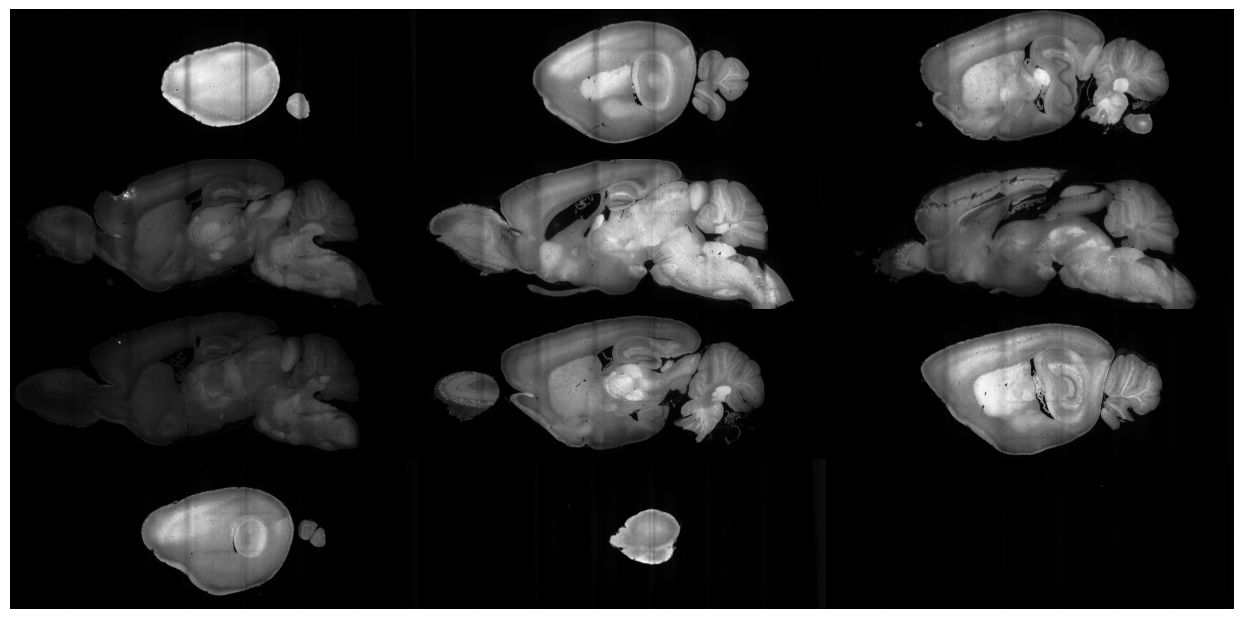

In [ ]:
template.plot()